# Build 3 layer deep neural network for non linear regression using Tensorflow various variants low level, api, functional, model, builtin

# 1.  Tensorflow only from scratch not using high level api

## Step 1: Import Libraries and Generate Synthetic Data
This step involves generating the synthetic data based on a non-linear equation and plotting it.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [7]:

# Generate synthetic data
def generate_data(size=1000):
    x = np.random.uniform(-3, 3, (size, 3))
    y = np.sin(x[:, 0]) + x[:, 1]**2 - np.log(1 + np.abs(x[:, 2])) + np.random.normal(0, 0.1, size)
    return x.astype(np.float32), y.reshape(-1, 1).astype(np.float32)

x_np, y_np = generate_data()


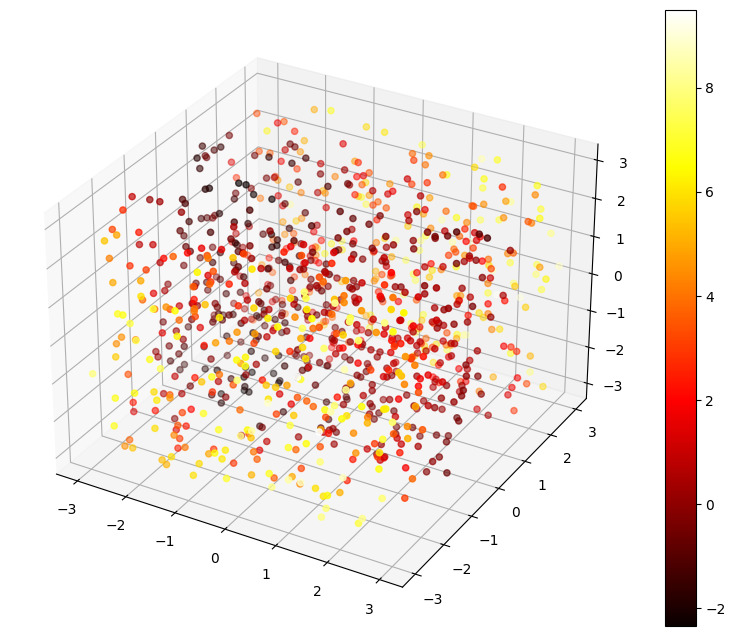

In [8]:

# Plotting function
def plot_4d(x, y):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y.squeeze(), cmap=plt.hot())
    fig.colorbar(p)
    plt.show()

# Plot the synthetic data
plot_4d(x_np, y_np)


## Step 2: Define the Neural Network Parameters and Forward Pass
In this step, we manually define the weights and biases of the network and implement the forward pass using tf.einsum for matrix multiplication and adding non-linearity with the ReLU activation function.

In [9]:
class ThreeLayerNet:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # Initialize weights and biases
        initializer = tf.initializers.GlorotUniform()

        self.W1 = tf.Variable(initializer((input_dim, hidden_dim)))
        self.b1 = tf.Variable(tf.zeros([hidden_dim]))
        self.W2 = tf.Variable(initializer((hidden_dim, hidden_dim)))
        self.b2 = tf.Variable(tf.zeros([hidden_dim]))
        self.W3 = tf.Variable(initializer((hidden_dim, output_dim)))
        self.b3 = tf.Variable(tf.zeros([output_dim]))

    def call(self, inputs):
        z1 = tf.einsum('ij,jk->ik', inputs, self.W1) + self.b1
        a1 = tf.nn.relu(z1)
        z2 = tf.einsum('ij,jk->ik', a1, self.W2) + self.b2
        a2 = tf.nn.relu(z2)
        z3 = tf.einsum('ij,jk->ik', a2, self.W3) + self.b3
        return z3  # Linear output for regression

model = ThreeLayerNet(3, 64, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


## Step 3: Training Loop
This part involves defining the loss function, the optimizer, and the training loop where we'll use tf.GradientTape for gradient computation.

In [10]:
# Loss function and optimizer
loss_fn = tf.losses.MeanSquaredError()
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
def train_step(model, inputs, outputs, loss_fn):
    with tf.GradientTape() as tape:
        predictions = model.call(inputs)
        loss = loss_fn(outputs, predictions)
    gradients = tape.gradient(loss, vars(model).values())
    optimizer.apply_gradients(zip(gradients, vars(model).values()))
    return loss

# Prepare the data
x_tensor = tf.constant(x_np)
y_tensor = tf.constant(y_np)

# Run the training loop
epochs = 1000
losses = []

for epoch in range(epochs):
    loss = train_step(model, x_tensor, y_tensor, loss_fn)
    losses.append(loss)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')


Epoch 0, Loss: 14.301398277282715
Epoch 100, Loss: 0.1576106697320938
Epoch 200, Loss: 0.040279895067214966
Epoch 300, Loss: 0.01689882017672062
Epoch 400, Loss: 0.014124403707683086
Epoch 500, Loss: 0.014051584526896477
Epoch 600, Loss: 0.01142029371112585
Epoch 700, Loss: 0.013616167940199375
Epoch 800, Loss: 0.010452665388584137
Epoch 900, Loss: 0.011900856159627438


## Step 4: Plot Training Loss
Plotting the training loss over epochs to visualize the learning process.

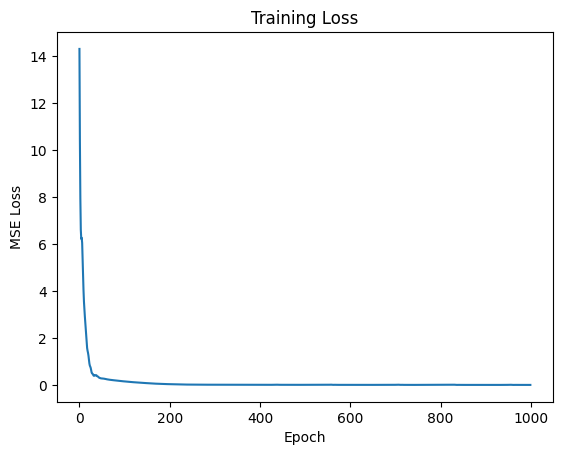

In [11]:
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()


## Step 5: Predictions and Actual vs. Predicted Plot
Finally, making predictions with the trained model and plotting actual vs. predicted values.

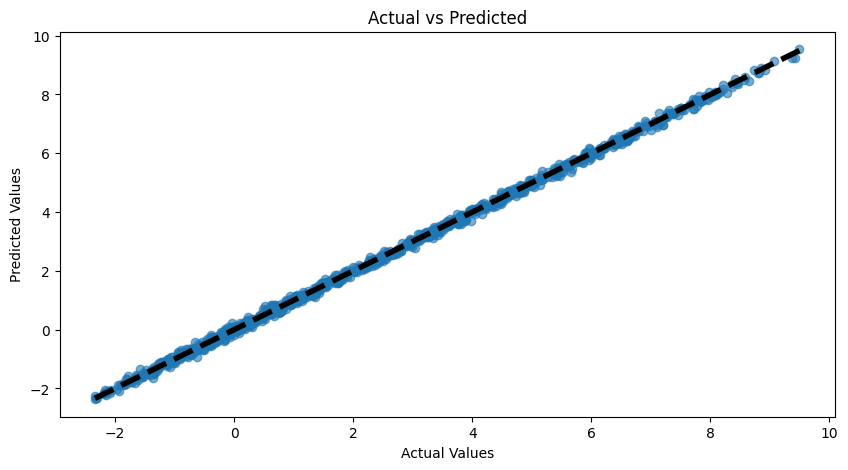

In [13]:
predictions = model.call(x_tensor)

plt.figure(figsize=(10, 5))
plt.scatter(y_np, predictions.numpy(), alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.plot([y_np.min(), y_np.max()], [y_np.min(), y_np.max()], 'k--', lw=4)  # Line for perfect predictions
plt.show()


# 2. Tensorflow only with builtin layers

## Step 1: Install TensorFlow and Import Libraries

In [14]:
!pip install tensorflow matplotlib


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models


## Step 2: Generate and Plot Synthetic Data
Generate synthetic data based on a given non-linear equation and plot it using Matplotlib.

In [16]:
def generate_data(size=1000):
    x = np.random.uniform(-3, 3, (size, 3))
    y = np.sin(x[:, 0]) + x[:, 1]**2 - np.log(1 + np.abs(x[:, 2])) + np.random.normal(0, 0.1, size)
    return x.astype(np.float32), y.reshape(-1, 1).astype(np.float32)

x_np, y_np = generate_data()



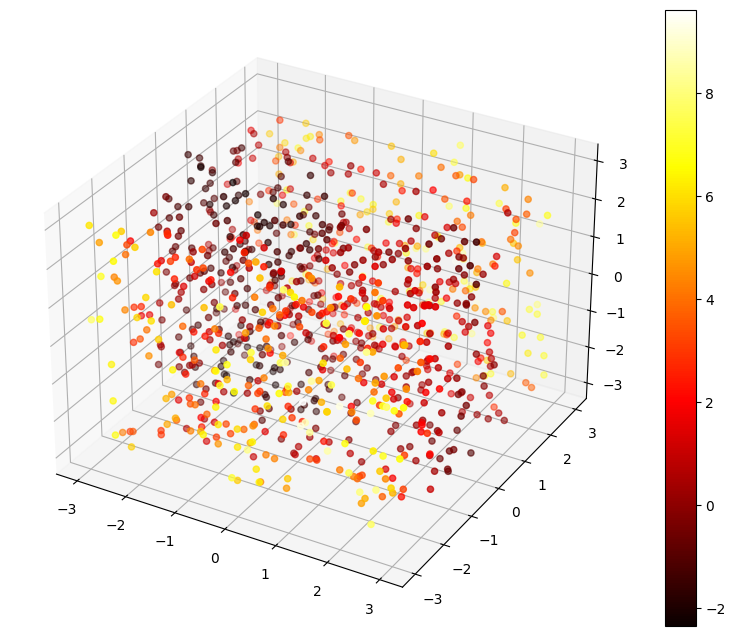

In [17]:
def plot_4d(x, y):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y.squeeze(), cmap=plt.hot())
    fig.colorbar(img)
    plt.show()

plot_4d(x_np, y_np)


## Step 3: Define a Custom Layer Using einsum
Create a custom TensorFlow layer that utilizes einsum for matrix multiplication.

In [18]:
class CustomDense(tf.keras.layers.Layer):
    def __init__(self, units=32, activation=None):
        super(CustomDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        return self.activation(tf.einsum('ij,jk->ik', inputs, self.w) + self.b)


## Step 4: Build the Model Using Built-in and Custom Layers
Construct a 3-layer neural network model using the custom layer defined above.

In [20]:
model = tf.keras.Sequential([
    CustomDense(64, activation='relu'),  # TensorFlow infers input shape automatically
    CustomDense(64, activation='relu'),
    CustomDense(1)
])

model.build(input_shape=(None, 3))  # Explicitly specifying input shape for the model
model.compile(optimizer='adam', loss='mse')


## Step 5: Train the Model and Plot Training Loss
Train the model on the synthetic data and plot the training loss.

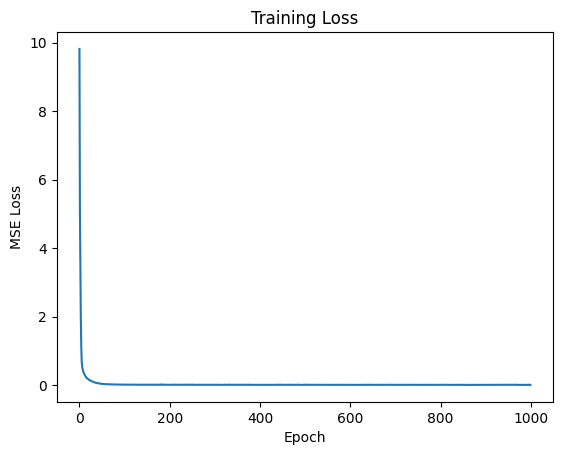

In [21]:
history = model.fit(x_np, y_np, epochs=1000, verbose=0)

plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()


## Step 6: Predictions and Actual vs. Predicted Plot
Make predictions with the trained model and visualize the actual vs. predicted values.

32/32 [==============================] - 0s 2ms/step


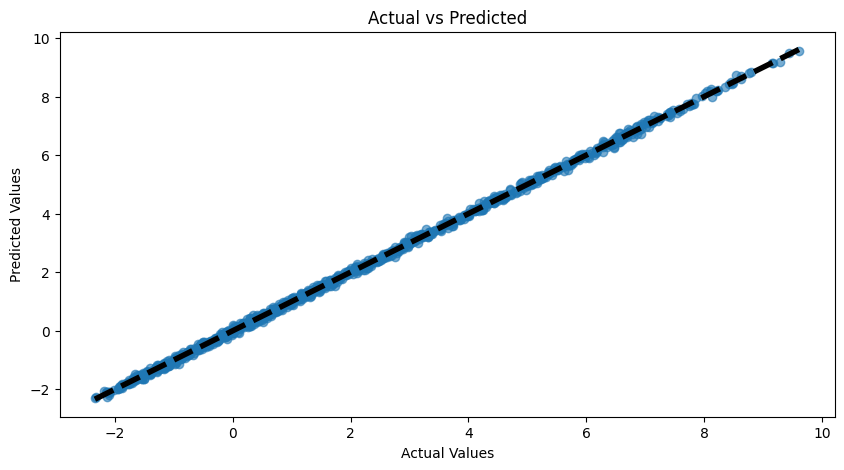

In [22]:
predictions = model.predict(x_np)

plt.figure(figsize=(10, 5))
plt.scatter(y_np, predictions, alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.plot([y_np.min(), y_np.max()], [y_np.min(), y_np.max()], 'k--', lw=4)  # Perfect predictions line
plt.show()


# 3. Using functional Api high level api of tensorflow

## Step 1: Import Libraries and Generate Synthetic Data

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [24]:
def generate_data(size=1000):
    x = np.random.uniform(-3, 3, (size, 3))
    y = np.sin(x[:, 0]) + x[:, 1]**2 - np.log(1 + np.abs(x[:, 2])) + np.random.normal(0, 0.1, size)
    return x.astype(np.float32), y.reshape(-1, 1).astype(np.float32)

x_np, y_np = generate_data()


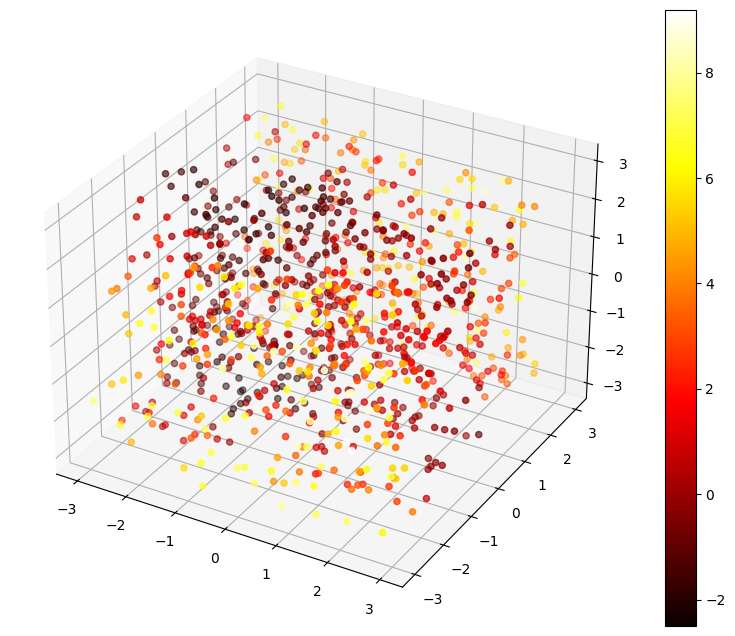

In [25]:

def plot_4d(x, y):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y.squeeze(), cmap=plt.hot())
    fig.colorbar(img)
    plt.show()

plot_4d(x_np, y_np)

## Step 2: Define Custom Layer Using einsum

In [26]:
class CustomDenseLayer(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(CustomDenseLayer, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        return self.activation(tf.einsum('ij,jk->ik', inputs, self.w) + self.b)


## Step 3: Build the Model Using TensorFlow Functional API

In [27]:
inputs = tf.keras.Input(shape=(3,))
x = CustomDenseLayer(64, activation='relu')(inputs)
x = CustomDenseLayer(64, activation='relu')(x)
outputs = CustomDenseLayer(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')


## Step 4: Train the Model and Plot Training Loss

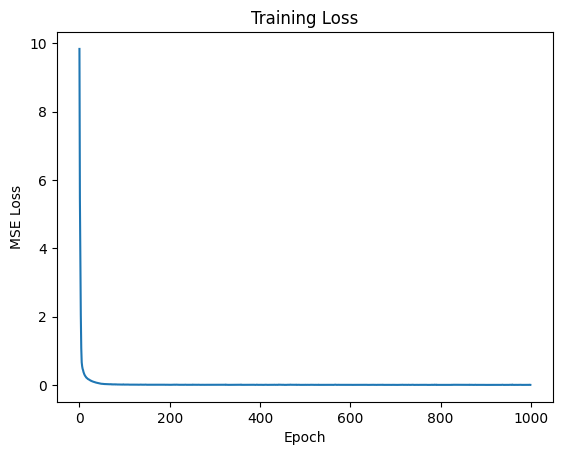

In [28]:
history = model.fit(x_np, y_np, epochs=1000, verbose=0)

plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()


## Step 5: Predictions and Actual vs. Predicted Plot

32/32 [==============================] - 0s 2ms/step


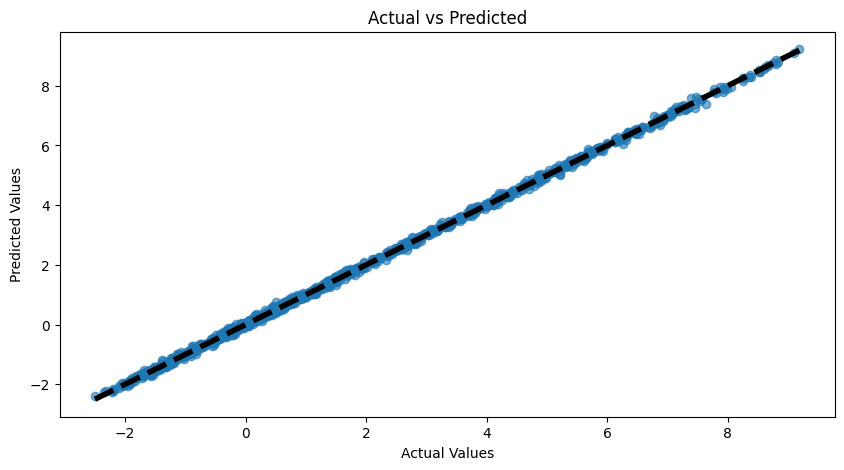

In [29]:
predictions = model.predict(x_np)

plt.figure(figsize=(10, 5))
plt.scatter(y_np, predictions, alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.plot([y_np.min(), y_np.max()], [y_np.min(), y_np.max()], 'k--', lw=4)  # Line for perfect predictions
plt.show()


# 4. Perform same using only Tensorflow high level api

## Step 1: Import Libraries and Generate Synthetic Data

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
def generate_data(size=1000):
    x = np.random.uniform(-3, 3, (size, 3))
    y = np.sin(x[:, 0]) + x[:, 1]**2 - np.log(1 + np.abs(x[:, 2])) + np.random.normal(0, 0.1, size)
    return x.astype(np.float32), y.reshape(-1, 1).astype(np.float32)

x_np, y_np = generate_data()



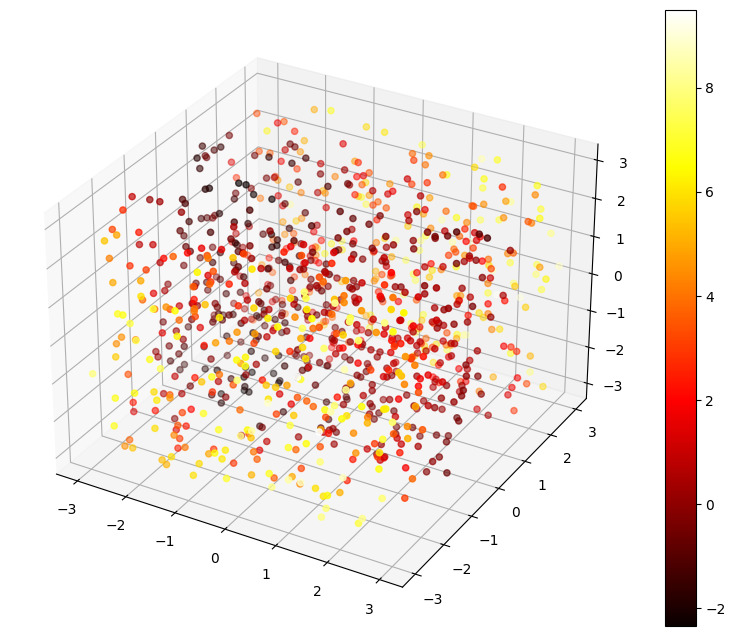

In [32]:
def plot_4d(x, y):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=y.squeeze(), cmap=plt.hot())
    fig.colorbar(img)
    plt.show()

plot_4d(x_np, y_np)

## Step 2: Define Custom Layer Using `einsum`

In [33]:
class CustomDenseLayer(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(CustomDenseLayer, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        return self.activation(tf.einsum('ij,jk->ik', inputs, self.w) + self.b)


## Step 3: Build the Model Using TensorFlow's Sequential API

In [35]:
model = tf.keras.Sequential([
    CustomDenseLayer(64, activation='relu'),
    CustomDenseLayer(64, activation='relu'),
    CustomDenseLayer(1)
])

model.build(input_shape=(None, 3))
model.compile(optimizer='adam', loss='mse')


## Step 4: Train the Model and Plot Training Loss

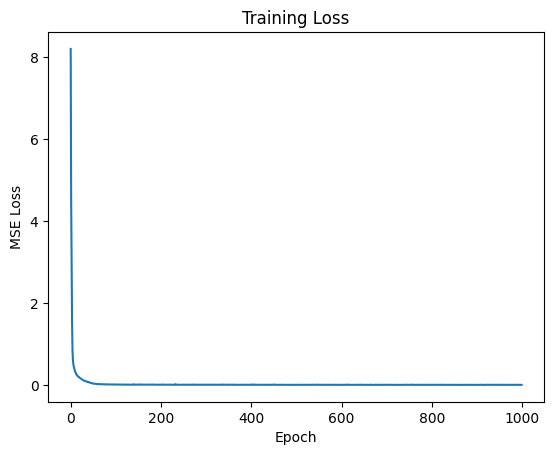

In [36]:
history = model.fit(x_np, y_np, epochs=1000, batch_size=32, verbose=0)

plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()


## Step 5: Predictions and Actual vs. Predicted Plot

32/32 [==============================] - 0s 1ms/step


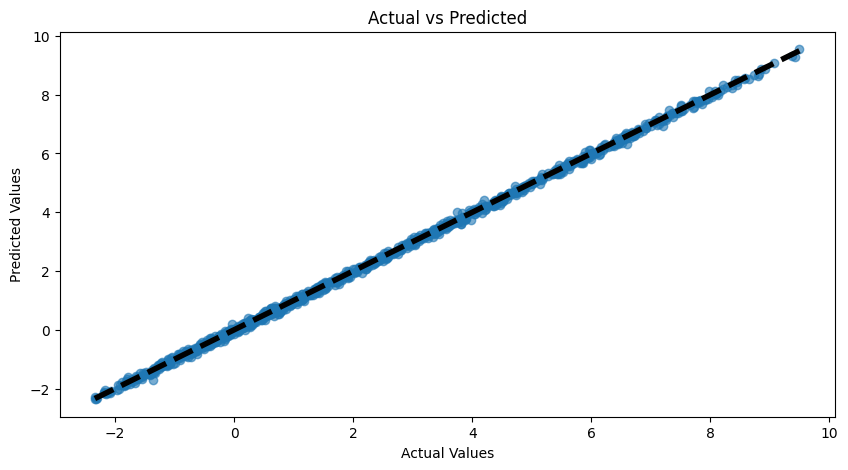

In [37]:
predictions = model.predict(x_np)

plt.figure(figsize=(10, 5))
plt.scatter(y_np, predictions, alpha=0.6)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.plot([y_np.min(), y_np.max()], [y_np.min(), y_np.max()], 'k--', lw=4)  # Line for perfect predictions
plt.show()
